# Data analysis - BoligPortalen

In [44]:
# Import packages:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

In [45]:
# import data
bp_df = pd.read_csv('boligportalen_df_location.csv')
bp_df.head(15000)

Adress       City  \
0           Albanigade, 5000 Odense, Odense C  - 2. sal     Odense   
1                      Hovedgaden, 8410 Rønde  - 1. sal      Rønde   
2      Digmannsvej, 9400 Aalborg, Nørresundby  - 1. sal    Aalborg   
3      Lyngbyvej, 2100 København, København Ø  - 2. sal  København   
4        Skejbygårdsvej, 8240 Aarhus, Risskov  - 2. sal     Aarhus   
...                                                 ...        ...   
14381   Urtehaven, 2640 København, Hedehusene  - 2. sal  København   
14382                            Hvesager, 7300 Jelling    Jelling   
14383                      Bybækterrasserne, 3520 Farum      Farum   
14384                    Bakkeborgdalen, 8600 Silkeborg  Silkeborg   
14385                        Tusindfryd, 8600 Silkeborg  Silkeborg   

            Street name  Postal code   Latitude  Longitude Monthly rent  \
0            Albanigade       5000.0  55.393856  10.394185    5.400 kr.   
1            Hovedgaden       8410.0  56.300211  10.477949    7.100 kr.   
2           Digmannsvej       9400.0  57.057390   9.936155    5.800 kr.   
3             Lyngbyvej       2100.0  55.721333  12.556324    8.200 kr.   
4        Skejbygårdsvej       8240.0  56.199538  10.198303    8.195 kr.   
...                 ...          ...        ...        ...          ...   
14381         Urtehaven       2640.0  55.645165  12.200624   10.350 kr.   
14382          Hvesager       7300.0  55.748925   9.407440    3.046 kr.   
14383  Bybækterrasserne       3520.0  55.818869  12.379435    2.400 kr.   
14384    Bakkeborgdalen       8600.0  56.203631   9.614604    9.395 kr.   
14385        Tusindfryd       8600.0  56.196480   9.620974   10.000 kr.   

        Aconto Square meters  Rooms  ... Shareable Pets allowed Elevator  \
0      800 kr.         62 m²    2.0  ...       Nej          Nej       Ja   
1      700 kr.        100 m²    4.0  ...       Nej           Ja      Nej   
2      300 kr.         64 m²    2.0  ...       Nej          Nej      Nej   
3      500 kr.         43 m²    1.0  ...       Nej          Nej      Nej   
4      600 kr.         60 m²    3.0  ...        Ja           Ja       Ja   
...        ...           ...    ...  ...       ...          ...      ...   
14381  950 kr.         76 m²    2.0  ...       Nej           Ja      Nej   
14382  420 kr.         31 m²    1.0  ...       Nej           Ja      Nej   
14383  900 kr.         12 m²    1.0  ...        Ja           Ja      Nej   
14384      NaN        110 m²    4.0  ...       Nej           Ja      Nej   
14385    0 kr.         97 m²    3.0  ...        Ja           Ja      Nej   

      Senior frendly Only for students Balcony/Terrace Parking Energy label  \
0                Nej               Nej             Nej     Nej          NaN   
1                Nej               Nej             Nej     Nej            D   
2                Nej               Nej              Ja      Ja          NaN   
3                Nej                Ja             Nej     Nej          NaN   
4                 Ja               Nej              Ja      Ja          NaN   
...              ...               ...             ...     ...          ...   
14381            Nej               Nej             Nej     Nej            A   
14382            Nej               Nej             Nej     Nej          NaN   
14383            Nej               Nej              Ja      Ja            C   
14384            Nej               Nej             Nej     Nej          NaN   
14385             Ja               Nej              Ja      Ja            A   

                                             Description  \
0      Boligen er en 2-værelses og udgør i alt 62,6 k...   
1      Lejligheden har 2 store sammenhængende stuer, ...   
2      Totalrenoveret lejlighed på 64 kvm. 2 vær. Lej...   
3      Velkommen til Rygården ll\n\nHer finder du nyo...   
4      Velindrettet delevenlig 3-værelses kvalitetsle...   
...                                                  ...   
14381  Ejendommen\nModern

In [46]:
# Cleaning and transforming data from BoligPortalen:

# Delete Adress, Street name, Description and Link columns:
bp_df = bp_df.drop(['Adress', 'Street name', 'Description', 'Link'], axis=1)

# Transform data to correct format
bp_df['Monthly rent'] = bp_df['Monthly rent'].str.replace(' kr.', '').str.replace('.', '')
bp_df['Aconto'] = bp_df['Aconto'].str.replace(' kr.', '').str.replace('.', '')
bp_df['Square meters'] = bp_df['Square meters'].str.replace(' m²', '').str.replace('.', '')
bp_df['Rooms'] = bp_df['Rooms'].astype(str).str.replace('.0', '')
bp_df['Floor'] = bp_df['Floor'].astype(str).str.replace('.', '')
bp_df['Floor'] = bp_df['Floor'].str.replace('Stuen', '0')
bp_df['Floor'] = bp_df['Floor'].str.replace('Kælder', '-1')

# Convert to dummy variables
# Mapping for 'Nej' to 0 and 'Ja' to 1
mapping = {'Nej': 0, 'Ja': 1}

# List of columns to be converted
columns_to_convert = ['Furnished', 'Shareable', 'Pets allowed', 'Elevator', 'Senior frendly',
                      'Only for students', 'Balcony/Terrace', 'Parking']

# Apply mapping to specified columns
bp_df[columns_to_convert] = bp_df[columns_to_convert].replace(mapping)

# Replace "-" with NaN in the entire DataFrame
bp_df.replace("-", np.nan, inplace=True)

# Columns to convert to float
float_columns = [
    "Monthly rent", "Aconto", "Square meters", "Rooms", "Floor",
    "Furnished", "Shareable", "Pets allowed", "Elevator", "Senior frendly",
    "Only for students", "Balcony/Terrace", "Parking",
]

# Clean and convert columns to float
for col in float_columns:
    if bp_df[col].dtype == object:
        bp_df[col] = pd.to_numeric(bp_df[col].str.replace(',', ''), errors='coerce')

# Convert postal code to numeric (float) and then to int
bp_df['Postal code'] = pd.to_numeric(bp_df['Postal code'], errors='coerce').astype('Int64')

# Drop all rows with ['Property type'] != 'Lejlighed':
bp_df = bp_df[bp_df['Property type'] == 'Lejlighed']

# Count the occurrences of "Lejlighed" in the "Property type" column
lejlighed_count = (bp_df['Property type'] == 'Lejlighed').sum()

# Print the count
print("Number of 'Lejligheder':", lejlighed_count)

bp_df.head(50)

Number of 'Lejligheder': 11669


City  Postal code   Latitude  Longitude  Monthly rent  Aconto  \
0       Odense         5000  55.393856  10.394185        5400.0   800.0   
1        Rønde         8410  56.300211  10.477949        7100.0   700.0   
2      Aalborg         9400  57.057390   9.936155        5800.0   300.0   
3    København         2100  55.721333  12.556324        8200.0   500.0   
4       Aarhus         8240  56.199538  10.198303        8195.0   600.0   
5      Randers         8900  56.465990  10.034878        6300.0   650.0   
6        Odder         8300  55.973541  10.145876        7600.0   500.0   
7      Esbjerg         6700  55.465056   8.456541        8500.0   700.0   
9        Sunds         7451  56.204861   9.015997        5995.0     0.0   
10      Vojens         6500  55.243910   9.299112        5250.0  1250.0   
11     Horsens         8700  55.871169   9.839791        8458.0   375.0   
12      Odense         5000  55.399701  10.389513        9900.0  1000.0   
14    Agerskov         6534  55.130128   9.131757        4863.0  1251.0   
15     Vamdrup         6580  55.425215   9.285583        5220.0   650.0   
16   Haderslev         6100  55.253774   9.501007        5650.0   849.0   
17  Sønderborg         6400  54.911939   9.794497        5500.0   550.0   
18   Vildbjerg         7480  56.196107   8.772983        6240.0     0.0   
19    Aabenraa         6200  55.044687   9.418649        7950.0  1200.0   
20      Odense         5000  55.400721  10.392720        5950.0   800.0   
22   Hedensted         8722  55.765170   9.692598        7745.0  1000.0   
23     Kolding         6000  55.491320   9.469015        6055.0  1140.0   
24      Odense         5000  55.401843  10.408874       10800.0     NaN   
25   København         1173  55.681471  12.574214       16829.0  1100.0   
27      Aarhus         8381  56.185439  10.126467        6076.0   200.0   
29   Haderslev         6100  55.249473   9.488304        6150.0  1800.0   
30      Aarhus         8230  56.149380  10.166026        9200.0   400.0   
31       Tjele         8830  56.499693   9.503079        3700.0   700.0   
32     Aabybro         9440  57.162633   9.729640        5900.0   600.0   
33   Grindsted         7200  55.751674   8.928588        3977.0   509.0   
34   Aalestrup         9620  56.693640   9.492536        4800.0   600.0   
35   Silkeborg         8600  56.137850   9.565094       11995.0     0.0   
36     Løgstør         9670  56.970023   9.277769        2950.0  1000.0   
37     Horsens         8700  55.867855   9.846178        7000.0     0.0   
38     Kolding         6000  55.485657   9.498978        9850.0  1100.0   
39      Aarhus         8230  56.149784  10.171438       11440.0  1000.0   
40    Slagelse         4200  55.412035  11.358924       10500.0     NaN   
41      Aarhus         8200  56.179073  10.199313        8700.0   400.0   
43     Aalborg         9000  57.046424   9.939320        4658.0   700.0   
44      Odense         5000  55.401633  10.389421        7054.0  1000.0   
45     Aalborg         9000  57.051328   9.907304        6400.0   450.0   
46      Aarhus         8270  56.116617  10.206425        5850.0   250.0   
47   København         2640  55.648132  12.195966       12400.0  1000.0   
48       Hobro         9500  56.635773   9.793054        4000.0   600.0   
49     Aalborg         9000  57.042346   9.938284        5128.0   650.0   
50     Aalborg         9000  57.033678   9.935609        7750.0   500.0   
51   Silkeborg         8600  56.175321   9.493281        9295.0   350.0   
52   København         2300  55.617429  12.566277       11050.0   800.0   
53      Viborg         8800  56.449946   9.414883        5000.0  1000.0   
54   Gilleleje         3250  56.122423  12.308948       12900.0  1000.0   
55     Randers         8900  56.463763  10.018442        5285.0   992.0   

    Square meters  Rooms  Floor Property type  Furnished  Shareable  \
0            62.0    2.0    2.0     Lejlighed        0.0        0.0   
1           100.0    4.0    1.0     Lejlig

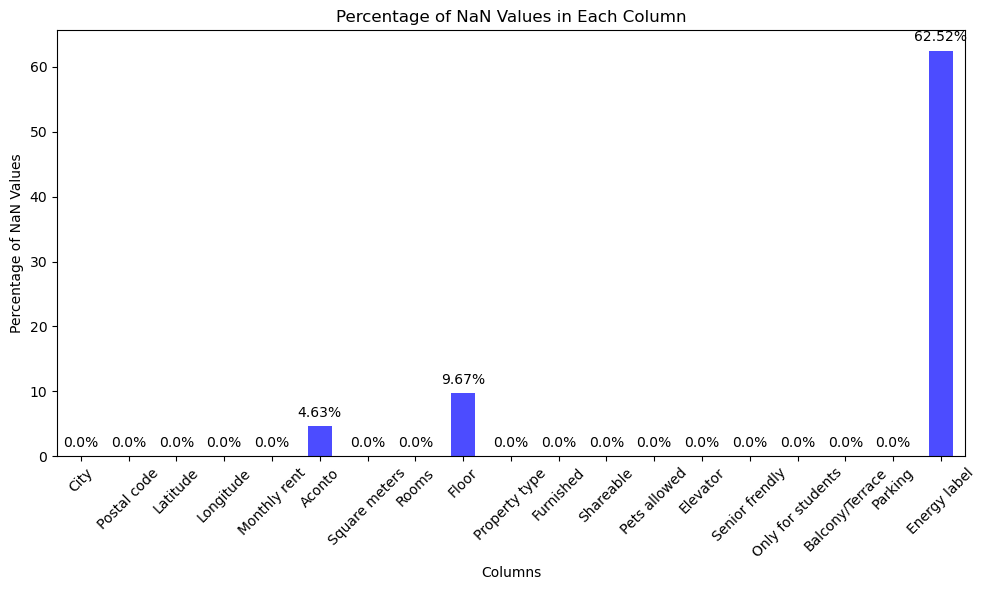

In [47]:
# Calculate the percentage of NaN values in each column
nan_percentages = (bp_df.isna().mean() * 100).round(2)

# Plot the bar plot
plt.figure(figsize=(10, 6))
nan_percentages.plot(kind='bar', color='blue', alpha=0.7)

# Add percentage labels on top of the bars
for index, value in enumerate(nan_percentages):
    plt.text(index, value + 1, f"{value}%", ha='center', va='bottom', fontsize=10, color='black')

plt.title("Percentage of NaN Values in Each Column")
plt.xlabel("Columns")
plt.ylabel("Percentage of NaN Values")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [48]:
# Function to categorize postal codes
def categorize_postal_code(postal_code):
    # Floor divide by 1000 to get the category
    return f'{postal_code // 1000}000-{postal_code // 1000 + 1}999'

# Apply the function to the 'Postal code' column
bp_df['Postal Category'] = bp_df['Postal code'].apply(categorize_postal_code)

# Create dummy columns
postal_dummies = pd.get_dummies(bp_df['Postal Category'], prefix='PostalCode')

# Drop the 'Postal Category' column as it's not needed anymore
bp_df = bp_df.drop('Postal Category', axis=1)

# Concatenate the dummies to the original dataframe
bp_df = pd.concat([bp_df, postal_dummies], axis=1)

bp_df.head(50)

City  Postal code   Latitude  Longitude  Monthly rent  Aconto  \
0       Odense         5000  55.393856  10.394185        5400.0   800.0   
1        Rønde         8410  56.300211  10.477949        7100.0   700.0   
2      Aalborg         9400  57.057390   9.936155        5800.0   300.0   
3    København         2100  55.721333  12.556324        8200.0   500.0   
4       Aarhus         8240  56.199538  10.198303        8195.0   600.0   
5      Randers         8900  56.465990  10.034878        6300.0   650.0   
6        Odder         8300  55.973541  10.145876        7600.0   500.0   
7      Esbjerg         6700  55.465056   8.456541        8500.0   700.0   
9        Sunds         7451  56.204861   9.015997        5995.0     0.0   
10      Vojens         6500  55.243910   9.299112        5250.0  1250.0   
11     Horsens         8700  55.871169   9.839791        8458.0   375.0   
12      Odense         5000  55.399701  10.389513        9900.0  1000.0   
14    Agerskov         6534  55.130128   9.131757        4863.0  1251.0   
15     Vamdrup         6580  55.425215   9.285583        5220.0   650.0   
16   Haderslev         6100  55.253774   9.501007        5650.0   849.0   
17  Sønderborg         6400  54.911939   9.794497        5500.0   550.0   
18   Vildbjerg         7480  56.196107   8.772983        6240.0     0.0   
19    Aabenraa         6200  55.044687   9.418649        7950.0  1200.0   
20      Odense         5000  55.400721  10.392720        5950.0   800.0   
22   Hedensted         8722  55.765170   9.692598        7745.0  1000.0   
23     Kolding         6000  55.491320   9.469015        6055.0  1140.0   
24      Odense         5000  55.401843  10.408874       10800.0     NaN   
25   København         1173  55.681471  12.574214       16829.0  1100.0   
27      Aarhus         8381  56.185439  10.126467        6076.0   200.0   
29   Haderslev         6100  55.249473   9.488304        6150.0  1800.0   
30      Aarhus         8230  56.149380  10.166026        9200.0   400.0   
31       Tjele         8830  56.499693   9.503079        3700.0   700.0   
32     Aabybro         9440  57.162633   9.729640        5900.0   600.0   
33   Grindsted         7200  55.751674   8.928588        3977.0   509.0   
34   Aalestrup         9620  56.693640   9.492536        4800.0   600.0   
35   Silkeborg         8600  56.137850   9.565094       11995.0     0.0   
36     Løgstør         9670  56.970023   9.277769        2950.0  1000.0   
37     Horsens         8700  55.867855   9.846178        7000.0     0.0   
38     Kolding         6000  55.485657   9.498978        9850.0  1100.0   
39      Aarhus         8230  56.149784  10.171438       11440.0  1000.0   
40    Slagelse         4200  55.412035  11.358924       10500.0     NaN   
41      Aarhus         8200  56.179073  10.199313        8700.0   400.0   
43     Aalborg         9000  57.046424   9.939320        4658.0   700.0   
44      Odense         5000  55.401633  10.389421        7054.0  1000.0   
45     Aalborg         9000  57.051328   9.907304        6400.0   450.0   
46      Aarhus         8270  56.116617  10.206425        5850.0   250.0   
47   København         2640  55.648132  12.195966       12400.0  1000.0   
48       Hobro         9500  56.635773   9.793054        4000.0   600.0   
49     Aalborg         9000  57.042346   9.938284        5128.0   650.0   
50     Aalborg         9000  57.033678   9.935609        7750.0   500.0   
51   Silkeborg         8600  56.175321   9.493281        9295.0   350.0   
52   København         2300  55.617429  12.566277       11050.0   800.0   
53      Viborg         8800  56.449946   9.414883        5000.0  1000.0   
54   Gilleleje         3250  56.122423  12.308948       12900.0  1000.0   
55     Randers         8900  56.463763  10.018442        5285.0   992.0   

    Square meters  Rooms  Floor Property type  ...  Energy label  \
0            62.0    2.0    2.0     Lejlighed  ...           NaN   
1           100.0    4.0    1.0     Lejlighed  .

In [49]:
# Remove energy label
bp_df = bp_df.drop('Energy label', axis=1)

# Remove all rows with NaN values
bp_df = bp_df.dropna()

# Count the occurrences of "Lejlighed" in the "Property type" column
lejlighed_count = (bp_df['Property type'] == 'Lejlighed').sum()

# Print the count
print("Number of 'Lejligheder':", lejlighed_count)

Number of 'Lejligheder': 10114


In [50]:
# Save the dataframe as a csv file
bp_df.to_csv('BP_Final_Data.csv', index=False)


In [51]:
import folium
import pandas as pd
from IPython.display import display

# Define colors for each postal code range
def get_color(postal_code):
    if 0 <= postal_code < 1000:
        return 'blue'
    elif 1000 <= postal_code < 2000:
        return 'black'
    elif 2000 <= postal_code < 3000:
        return 'red'
    elif 3000 <= postal_code < 4000:
        return 'purple'
    elif 4000 <= postal_code < 5000:
        return 'orange'
    elif 5000 <= postal_code < 6000:
        return 'darkgreen'
    elif 6000 <= postal_code < 7000:
        return 'pink'
    elif 7000 <= postal_code < 8000:
        return 'cyan'
    elif 8000 <= postal_code < 9000:
        return 'darkblue'
    else:
        return 'brown'

# Create a base map centered at Denmark
denmark_map = folium.Map(location=[56, 10], zoom_start=6, tiles='CartoDB positron')

# Add markers to the map for each data point
for index, row in bp_df.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    postal_code = row['Postal code']

    # Skip rows with missing latitude or longitude
    if pd.notnull(latitude) and pd.notnull(longitude):
        folium.CircleMarker(
            location=[latitude, longitude],
            radius=1,
            color=get_color(postal_code),
            fill=True,
            fill_color=get_color(postal_code),
        ).add_to(denmark_map)

# Display the map
display(denmark_map)